# <span style="color:deepskyblue">How much you can't afford to live in Toronto</span>

In [1]:
import pandas as pd
import numpy as np
import pyspark
import os
import pgeocode
import folium
import matplotlib.pyplot as plt 
import branca.colormap as cm

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

print('Imports Done!')

Imports Done!


In [2]:
l1 = pd.read_csv('housing_toronto1.csv')
l2 = pd.read_csv('housing_toronto2.csv')

In [3]:
df_pandas = pd.concat([l1, l2], axis=0)

In [4]:
df_pandas.head(3)

,mls_number,price,address,above_grade_bedrooms,below_grade_bedrooms,bathrooms,community_name,land_size,annual_prop_tax
0,C5934229,"$1,280,000","112 RAMEAU DR\nToronto, Ontario M2H1V4",Above Grade\n3,Below Grade\n1,Total\n2,Community Name\nHillcrest Village,Land Size\n60 x 108 FT,"Annual Property Taxes\n$5,662.12"
1,W5933893,"$1,049,000","18 PARK BLVD\nToronto, Ontario M8W1G6",Above Grade\n2,NaN,Total\n1,Community Name\nLong Branch,Land Size\n44 x 106 FT,"Annual Property Taxes\n$4,316.10"
2,W5933791,"$1,799,000","39 BROADFIELD DR\nToronto, Ontario M9C1L4",Above Grade\n3,Below Grade\n1,Total\n4,Community Name\nMarkland Wood,Land Size\n63.21 x 105.87 FT,"Annual Property Taxes\n$6,123.43"


In [5]:
df_pandas.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1234 entries, 0 to 632
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   mls_number            1225 non-null   object
 1   price                 1225 non-null   object
 2   address               1225 non-null   object
 3   above_grade_bedrooms  1219 non-null   object
 4   below_grade_bedrooms  760 non-null    object
 5   bathrooms             1225 non-null   object
 6   community_name        1191 non-null   object
 7   land_size             1224 non-null   object
 8   annual_prop_tax       1194 non-null   object
dtypes: object(9)
memory usage: 96.4+ KB


### Adding `lat` and `long` columns:

In [6]:
df_pandas['postal_code'] = df_pandas['address'].str[-6:] 

In [7]:
df_pandas['postal_code'] = df_pandas['postal_code'].str[:3] + ' ' + df_pandas['postal_code'].str[3:8]
df_pandas['postal_code']

0      M2H 1V4
1      M8W 1G6
2      M9C 1L4
3      M6B 2K4
4      M9P 2P5
        ...   
628    M3B 2A5
629    M6B 1M7
630    M2R 2H8
631    M1L 1T9
632    M3J 1P6
Name: postal_code, Length: 1234, dtype: object

In [8]:
nomi = pgeocode.Nominatim('ca')
codes = df_pandas['postal_code'].to_list()

df_pandas['lat'] = nomi.query_postal_code(codes).latitude
df_pandas['long'] = nomi.query_postal_code(codes).longitude

df_pandas.loc[:, 'address':'long']

,address,above_grade_bedrooms,below_grade_bedrooms,bathrooms,community_name,land_size,annual_prop_tax,postal_code,lat,long
0,"112 RAMEAU DR\nToronto, Ontario M2H1V4",Above Grade\n3,Below Grade\n1,Total\n2,Community Name\nHillcrest Village,Land Size\n60 x 108 FT,"Annual Property Taxes\n$5,662.12",M2H 1V4,43.8015,-79.3577
1,"18 PARK BLVD\nToronto, Ontario M8W1G6",Above Grade\n2,NaN,Total\n1,Community Name\nLong Branch,Land Size\n44 x 106 FT,"Annual Property Taxes\n$4,316.10",M8W 1G6,43.6021,-79.5402
2,"39 BROADFIELD DR\nToronto, Ontario M9C1L4",Above Grade\n3,Below Grade\n1,Total\n4,Community Name\nMarkland Wood,Land Size\n63.21 x 105.87 FT,"Annual Property Taxes\n$6,123.43",M9C 1L4,43.6437,-79.5767
3,"1104 GLENGROVE AVE\nToronto, Ontario M6B2K4",Above Grade\n4,NaN,Total\n2,Community Name\nYorkdale-Glen Park,Land Size\n35 x 132.75 FT,"Annual Property Taxes\n$3,899.03",M6B 2K4,43.7081,-79.4479
4,"18 MADILL ST\nToronto, Ontario M9P2P5",Above Grade\n3,Below Grade\n2,Total\n2,Community Name\nKingsview Village-The Westway,Land Size\n50 x 136.58 FT,"Annual Property Taxes\n$4,189.71",M9P 2P5,43.6949,-79.5323
...,...,...,...,...,...,...,...,...,...,...
628,"5 DALEBERRY PL\nToronto, Ontario M3B2A5",Above Grade\n3,Below Grade\n2,Total\n4,Community Name\nBanbury-Don Mills,Land Size\n100 x 150 FT,"Annual Property Taxes\n$14,764.70",M3B 2A5,43.6075,-79.5013
629,"1068 BRIAR HILL AVE\nToronto, Ontario M6B1M7",Above Grade\n3,Below Grade\n3,Total\n6,Community Name\nBriar Hill-Belgravia,Land Size\n25.03 x 118.5 FT ; 25.03 Ft X 118.5...,"Annual Property Taxes\n$3,879.82",M6B 1M7,43.7500,-79.3978
630,"26 KENTON DR\nToronto, Ontario M2R2H8",Above Grade\n3,Below Grade\n2,Total\n2,Community Name\nNewtonbrook West,Land Size\n60 x 125 FT,"Annual Property Taxes\n$5,681.56",M2R 2H8,43.7390,-79.4692
631,"3117 ST CLAIR AVE E\nToronto, Ontario M1L1T9",Above Grade\n3,NaN,Total\n2,Community Name\nClairlea-Birchmount,Land Size\n54 x 92.4 FT,"Annual Property Taxes\n$3,772.64",M1L 1T9,43.7334,-79.3329


In [9]:
# save the new data
df_pandas.to_csv('all_listings.csv', sep=',', header=True, index=False)

In [10]:
df_pandas.price

0      $1,280,000
1      $1,049,000
2      $1,799,000
3      $1,659,900
4      $1,449,900
          ...    
628    $5,149,000
629    $2,198,000
630    $1,395,000
631      $870,000
632    $1,068,000
Name: price, Length: 1234, dtype: object

---

# Sparky-time

In [11]:
spark = SparkSession.builder.appName('Ronto').getOrCreate()

In [12]:
spark

In [13]:
# because viewing large Spark datasets are hard...
def easier(data):
    return data.limit(5).toPandas()

In [14]:
# load data
df = spark.read.option("header", True) \
                .option("multiLine", True) \
                .option("escape", "\"") \
                .csv("all_listings.csv")

In [15]:
df.printSchema()

root
 |-- mls_number: string (nullable = true)
 |-- price: string (nullable = true)
 |-- address: string (nullable = true)
 |-- above_grade_bedrooms: string (nullable = true)
 |-- below_grade_bedrooms: string (nullable = true)
 |-- bathrooms: string (nullable = true)
 |-- community_name: string (nullable = true)
 |-- land_size: string (nullable = true)
 |-- annual_prop_tax: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)



In [16]:
print((df.count(), len(df.columns)))

(1234, 12)


In [17]:
#df.show()
easier(df)

,mls_number,price,address,above_grade_bedrooms,below_grade_bedrooms,bathrooms,community_name,land_size,annual_prop_tax,postal_code,lat,long
0,C5934229,"$1,280,000","112 RAMEAU DR\nToronto, Ontario M2H1V4",Above Grade\n3,Below Grade\n1,Total\n2,Community Name\nHillcrest Village,Land Size\n60 x 108 FT,"Annual Property Taxes\n$5,662.12",M2H 1V4,43.8015,-79.3577
1,W5933893,"$1,049,000","18 PARK BLVD\nToronto, Ontario M8W1G6",Above Grade\n2,None,Total\n1,Community Name\nLong Branch,Land Size\n44 x 106 FT,"Annual Property Taxes\n$4,316.10",M8W 1G6,43.6021,-79.5402
2,W5933791,"$1,799,000","39 BROADFIELD DR\nToronto, Ontario M9C1L4",Above Grade\n3,Below Grade\n1,Total\n4,Community Name\nMarkland Wood,Land Size\n63.21 x 105.87 FT,"Annual Property Taxes\n$6,123.43",M9C 1L4,43.6437,-79.5767
3,W5933713,"$1,659,900","1104 GLENGROVE AVE\nToronto, Ontario M6B2K4",Above Grade\n4,None,Total\n2,Community Name\nYorkdale-Glen Park,Land Size\n35 x 132.75 FT,"Annual Property Taxes\n$3,899.03",M6B 2K4,43.7081,-79.4479
4,W5933721,"$1,449,900","18 MADILL ST\nToronto, Ontario M9P2P5",Above Grade\n3,Below Grade\n2,Total\n2,Community Name\nKingsview Village-The Westway,Land Size\n50 x 136.58 FT,"Annual Property Taxes\n$4,189.71",M9P 2P5,43.6949,-79.5323


In [18]:
# count missing values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+-----+-------+--------------------+--------------------+---------+--------------+---------+---------------+-----------+---+----+
|mls_number|price|address|above_grade_bedrooms|below_grade_bedrooms|bathrooms|community_name|land_size|annual_prop_tax|postal_code|lat|long|
+----------+-----+-------+--------------------+--------------------+---------+--------------+---------+---------------+-----------+---+----+
|         9|    9|      9|                  15|                 474|        9|            43|       10|             40|          9| 12|  12|
+----------+-----+-------+--------------------+--------------------+---------+--------------+---------+---------------+-----------+---+----+



## Preprocessing

In [19]:
numeric_cols = ['price', 'above_grade_bedrooms', 'below_grade_bedrooms', 'bathrooms', 'annual_prop_tax']
outlier_cols = ['price', 'area']

In [20]:
def format(data):
   
    # remove duplicate rows by id
    data.dropDuplicates(['mls_number'])
    
    # strip the strings and convert data type
    for column in numeric_cols:
        data = data.withColumn(column, regexp_replace(column, '[^0-9]', '').cast('int')) \
                   .fillna(0, subset=numeric_cols)
        
    # clean the 'community_name' column
    data = data.withColumn('community_name', regexp_replace(col('community_name'), '^.*\n', '')) \
                .fillna('Other')
    
    # convert 'lat' and 'long' to float
    data = data.withColumn('lat', data.lat.cast(FloatType()))
    data = data.withColumn('long', data.long.cast(FloatType()))
    
    # multiply the length and width to get the area and insert into a new column
    pattern = r'(\d+(\.\d+)?) x (\d+(\.\d+)?)'
    data = data.withColumn('length', regexp_extract(col('land_size'), pattern, 1).cast('float')) \
               .withColumn('width', regexp_extract(col('land_size'), pattern, 3).cast('float'))

    data = data.withColumn('area', round( (col('length') * col('width')) / 10.764, 2 ) )
    
    # remove outliers in columns
    lower_quantile = 0.05
    upper_quantile = 0.95
    
    for column in outlier_cols:
        # calculate the lower and upper bounds based on the quantiles
        bounds = data.approxQuantile(column, [lower_quantile, upper_quantile], 0.01)

        # Extract lower and upper bounds
        lower_bound = bounds[0]
        upper_bound = bounds[1]

        # Filter the DataFrame to keep rows within the bounds
        data = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    
    # combine bedrooms columns
    data = data.withColumn('bedrooms', data['above_grade_bedrooms'] + data['below_grade_bedrooms'])
    
    # remove columns
    data = data.drop('mls_number', 'address', 'above_grade_bedrooms', 'below_grade_bedrooms', \
                     'land_size', 'annual_prop_tax', 'postal_code')
    
    # reorder columns
    data = data.select('price', 'community_name', 'bedrooms', 'bathrooms', 'area', 'lat', 'long')
    
    return data



In [21]:
dfc = format(df)
dfc.printSchema()

root
 |-- price: integer (nullable = true)
 |-- community_name: string (nullable = false)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: integer (nullable = true)
 |-- area: double (nullable = true)
 |-- lat: float (nullable = true)
 |-- long: float (nullable = true)



In [22]:
print((dfc.count(), len(dfc.columns)))

(941, 7)


In [23]:
dfc.show()

+-------+--------------------+--------+---------+------+-------+--------+
|  price|      community_name|bedrooms|bathrooms|  area|    lat|    long|
+-------+--------------------+--------+---------+------+-------+--------+
|1280000|   Hillcrest Village|       4|        2|602.01|43.8015|-79.3577|
|1049000|         Long Branch|       2|        1| 433.3|43.6021|-79.5402|
|1799000|       Markland Wood|       4|        4|621.71|43.6437|-79.5767|
|1659900|  Yorkdale-Glen Park|       4|        2|431.65|43.7081|-79.4479|
|1449900|Kingsview Village...|       5|        2|634.43|43.6949|-79.5323|
|1849000|Birchcliffe-Cliff...|       4|        4|232.26|43.6952|-79.2646|
|1888000|    Lansing-Westgate|       4|        2|510.96|43.7673|-79.4111|
|3629000| Mount Pleasant East|       6|        4|419.73| 43.702|-79.3853|
|1200000|Downsview-Roding-CFB|       4|        3| 573.3|43.7319|-79.4928|
|1249000|              Mimico|       4|        3|373.58|43.6075|-79.5013|
|1049999|Briar Hill-Belgravia|       3

In [24]:
dfc.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfc.columns]).show()

+-----+--------------+--------+---------+----+---+----+
|price|community_name|bedrooms|bathrooms|area|lat|long|
+-----+--------------+--------+---------+----+---+----+
|    0|             0|       0|        0|   0|  6|   6|
+-----+--------------+--------+---------+----+---+----+



## EDA

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'bedrooms'}>],
       [<Axes: title={'center': 'bathrooms'}>,
        <Axes: title={'center': 'area'}>]], dtype=object)

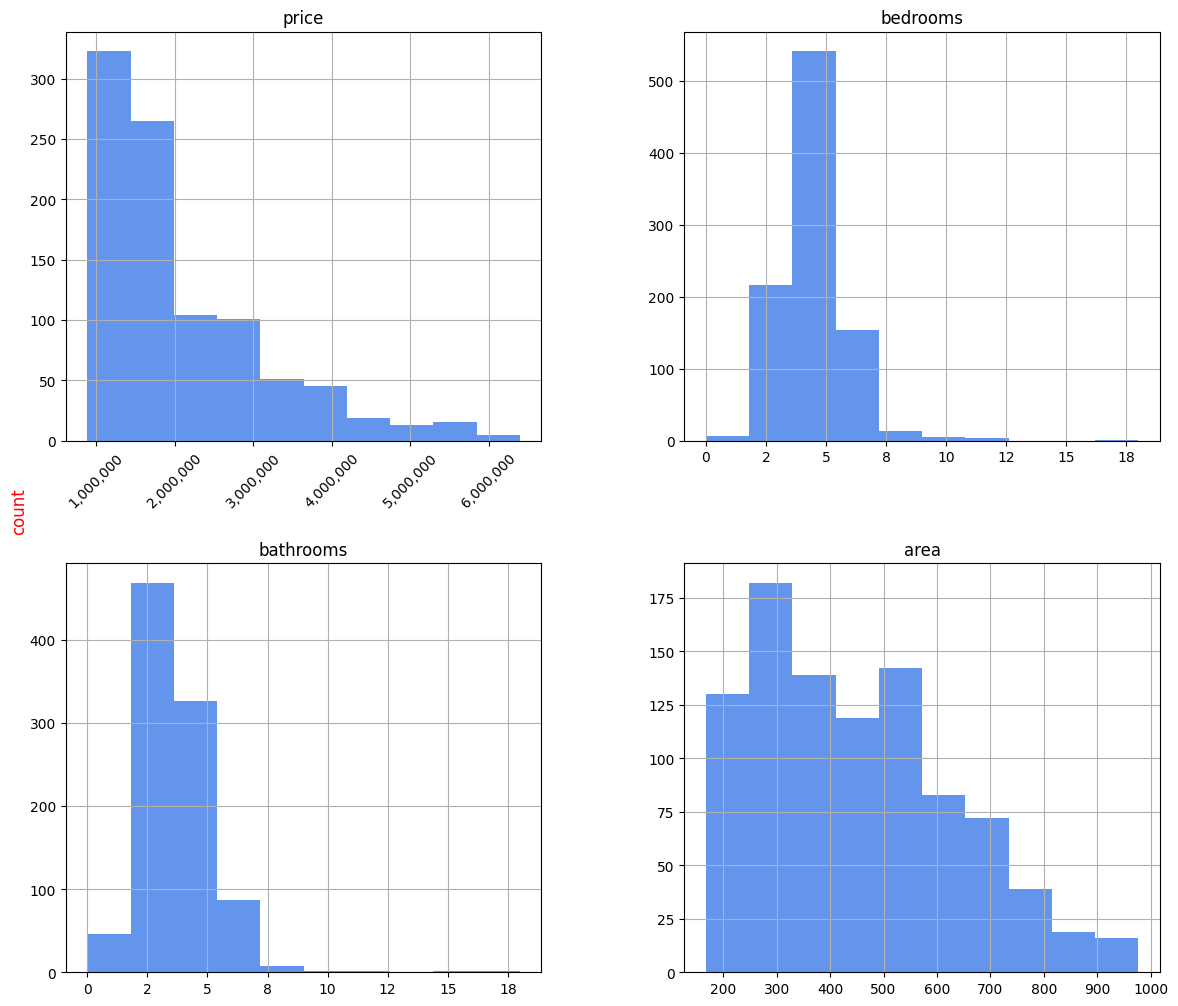

In [25]:
from matplotlib.ticker import StrMethodFormatter

dists = dfc.drop('long', 'lat', 'community_name')

fig, axis = plt.subplots(2, 2, figsize=(12, 10))

formatter = StrMethodFormatter('{x:,.0f}')

# price subplot
axis[0, 0].get_xaxis().set_major_formatter(formatter)
axis[0, 0].tick_params(axis='x', rotation=45)

# bedrooms subplot
axis[0, 1].get_xaxis().set_major_formatter(formatter)

# bathrooms subplot
axis[1, 0].get_xaxis().set_major_formatter(formatter)

fig.supylabel('count', color='r')
plt.tight_layout()

dists.toPandas().hist(ax=axis, color='cornflowerblue')

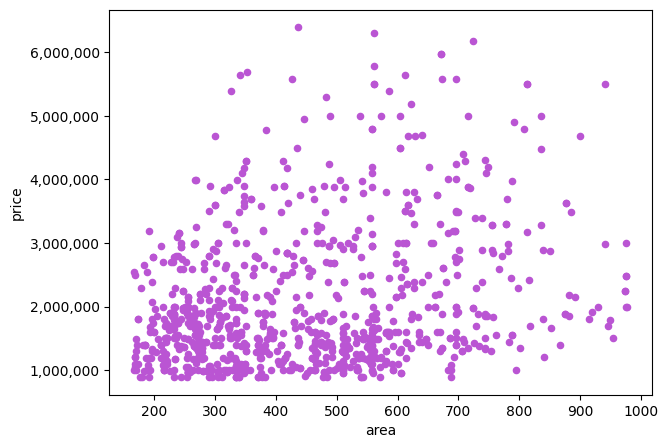

In [26]:
ax = dfc.toPandas().plot.scatter(x='area', y='price', c='mediumorchid', figsize=(7, 5));
ax.yaxis.set_major_formatter(formatter)

We can see more smaller houses (around 600 m^2) being in the lower end of the price spectrum. Although, properties this size still cost up to 6 MM!

In [27]:
dists.describe().select('summary',
                        round('price', 2).alias('price'),
                        round('bedrooms', 2).alias('bedrooms'),
                        round('bathrooms', 2).alias('bathrooms'),
                        round('area', 2).alias('area'),
                        ).show()

+-------+----------+--------+---------+------+
|summary|     price|bedrooms|bathrooms|  area|
+-------+----------+--------+---------+------+
|  count|     941.0|   941.0|    941.0| 941.0|
|   mean|2071453.26|    4.47|     3.48|448.87|
| stddev| 1080940.2|    1.44|     1.69| 185.3|
|    min|  889000.0|     0.0|      0.0|167.46|
|    max| 6395000.0|    18.0|     18.0|977.08|
+-------+----------+--------+---------+------+



In [28]:
from pyspark.ml.feature import Bucketizer

#specify bin ranges and column to bin
bucketizer = Bucketizer(splits=[0, 900000, 1800000, 2700000, 6000000, float('Inf')],
                        inputCol='price',
                        outputCol='bins')

#perform binning based on values in 'points' column
df_bins = bucketizer.setHandleInvalid('keep').transform(dfc)

#view new DataFrame
df_bins.show()

+-------+--------------------+--------+---------+------+-------+--------+----+
|  price|      community_name|bedrooms|bathrooms|  area|    lat|    long|bins|
+-------+--------------------+--------+---------+------+-------+--------+----+
|1280000|   Hillcrest Village|       4|        2|602.01|43.8015|-79.3577| 1.0|
|1049000|         Long Branch|       2|        1| 433.3|43.6021|-79.5402| 1.0|
|1799000|       Markland Wood|       4|        4|621.71|43.6437|-79.5767| 1.0|
|1659900|  Yorkdale-Glen Park|       4|        2|431.65|43.7081|-79.4479| 1.0|
|1449900|Kingsview Village...|       5|        2|634.43|43.6949|-79.5323| 1.0|
|1849000|Birchcliffe-Cliff...|       4|        4|232.26|43.6952|-79.2646| 2.0|
|1888000|    Lansing-Westgate|       4|        2|510.96|43.7673|-79.4111| 2.0|
|3629000| Mount Pleasant East|       6|        4|419.73| 43.702|-79.3853| 3.0|
|1200000|Downsview-Roding-CFB|       4|        3| 573.3|43.7319|-79.4928| 1.0|
|1249000|              Mimico|       4|        3|373

In [29]:
price_buckets = df_bins.groupBy('bins').agg(count('bins').alias('count')).orderBy(col('count').asc())
price_buckets.show()

+----+-----+
|bins|count|
+----+-----+
| 4.0|    3|
| 0.0|   26|
| 2.0|  213|
| 3.0|  214|
| 1.0|  485|
+----+-----+



Good news, the majority of the house prices are under **1.8 MM**

In [30]:
lat_mean = dfc.select(mean('lat')).collect()[0][0]
long_mean = dfc.select(mean('long')).collect()[0][0]

print(f'lat: {lat_mean} \nlog: {long_mean}')

lat: 43.71083293649602 
log: -79.40119504061612


In [31]:
# 'price' statistics
functions = [min, max, mean, median, stddev]
stats = []

for func in functions:
    result = dfc.select(func(dfc.price)).collect()[0][0] 
    stats.append(result)
    
print(f'min: ${stats[0]:,} \nmax: ${stats[1]:,} \nmean: ${stats[2]:,.2f} \
                           \nmedian: ${stats[3]:,.2f} \nstddev: ${stats[4]:,.2f}')

min: $889,000 
max: $6,395,000 
mean: $2,071,453.26                            
median: $1,699,000.00 
stddev: $1,080,940.20


In [32]:
coords = dfc.na.drop(subset=['long', 'lat'])

colormap = cm.LinearColormap(colors=["green", "yellow", "red"], vmin=stats[0], vmax=stats[1])

m = folium.Map(location=[lat_mean, long_mean], zoom_start=11)
for i in coords.rdd.toLocalIterator():   
        deets = [i['community_name'], i['price']]
        folium.CircleMarker(        
          location=[i['lat'], i['long']],
          radius=5,  
          fill=True,
          fill_opacity=0.2,
          color=colormap(i['price']),
          popup = f"{deets[0]} \n${deets[1]:,}"
       ).add_to(m)
m.add_child(colormap)     

#m.save('city.html')

## Which community is *affluent*?

In [33]:
unaffordable = dfc.groupBy('community_name').avg('price')
most_unaffordable = unaffordable.orderBy('Avg(price)', ascending=False).select('community_name').first()['community_name']
print(most_unaffordable)

Forest Hill North


In [34]:
dfc.where(dfc.community_name=='Forest Hill North').show()

+-------+-----------------+--------+---------+------+-------+--------+
|  price|   community_name|bedrooms|bathrooms|  area|    lat|    long|
+-------+-----------------+--------+---------+------+-------+--------+
|5498000|Forest Hill North|       5|        5|562.06|43.7081|-79.4479|
|4288000|Forest Hill North|       5|        5|351.58|43.7113|-79.4195|
|4099900|Forest Hill North|       7|        7|343.98|43.7063|-79.3094|
|6298000|Forest Hill North|       5|        7|562.06|43.6684|-79.3689|
|4288000|Forest Hill North|       5|        5|351.58|43.7694|-79.4921|
|5498000|Forest Hill North|       5|        5|562.06|43.7568| -79.521|
+-------+-----------------+--------+---------+------+-------+--------+



## Linear Regression

In [35]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors 
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer

In [36]:
indexer = StringIndexer(inputCol = 'community_name', outputCol = 'community_name_cat')
indexed = indexer.fit(dfc).transform(dfc)

In [37]:
assembler = VectorAssembler(
    inputCols=['bedrooms', 'bathrooms', 'area', 'lat', 'long', 'community_name_cat'],
    outputCol='features')

In [38]:
output = assembler.setHandleInvalid('skip').transform(indexed)

In [39]:
output.select('features', 'price').show(3, truncate=False)

+-----------------------------------------------------------+-------+
|features                                                   |price  |
+-----------------------------------------------------------+-------+
|[4.0,2.0,602.01,43.80149841308594,-79.35769653320312,76.0] |1280000|
|[2.0,1.0,433.3,43.60210037231445,-79.54019927978516,17.0]  |1049000|
|[4.0,4.0,621.71,43.643699645996094,-79.57669830322266,81.0]|1799000|
+-----------------------------------------------------------+-------+
only showing top 3 rows



In [40]:
result = output.select('features', 'price')

In [41]:
train_data, test_data = result.randomSplit([0.8, 0.2], seed=42)

In [42]:
train_data.describe().show()

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|              783|
|   mean|2064154.901660281|
| stddev|1083466.240712399|
|    min|           889000|
|    max|          6298000|
+-------+-----------------+



In [43]:
lr = LinearRegression(featuresCol='features', labelCol='price', predictionCol='predicted_price')
lr_model = lr.fit(train_data)

In [44]:
predictions = lr_model.transform(test_data)

evaluator = RegressionEvaluator(labelCol='price', predictionCol='predicted_price', metricName='rmse')
rmse = evaluator.evaluate(predictions)
print(f'Root Mean Squared Error (RMSE) on test data: {rmse:.3f}')

evaluator_r2 = RegressionEvaluator(labelCol='price', predictionCol='predicted_price', metricName='r2')
r2 = evaluator_r2.evaluate(predictions)
print('R-squared (R2) on test data: {r2:.3f}')

Root Mean Squared Error (RMSE) on test data: 854498.741
R-squared (R2) on test data: {r2:.3f}


In [45]:
coefficients = lr_model.coefficients
intercept = lr_model.intercept

print(f'Coefficients: {coefficients}')
print(f'Intercept: {intercept:.3f}')

Coefficients: [-60464.42557768484,453456.34221577947,1055.1133979606893,-1687326.8683326503,-132496.68723938055,-3598.2851928694963]
Intercept: 63681618.513


In [46]:
coeff_df = pd.DataFrame({'Feature': ['Intercept'] + output.columns[2:-1], 'Co-efficients': np.insert(lr_model.coefficients.toArray(), 0, lr_model.intercept)})
coeff_df = coeff_df[['Feature', 'Co-efficients']]

In [47]:
coeff_df

,Feature,Co-efficients
0,Intercept,6.368162e+07
1,bedrooms,-6.046443e+04
2,bathrooms,4.534563e+05
3,area,1.055113e+03
4,lat,-1.687327e+06
5,long,-1.324967e+05
6,community_name_cat,-3.598285e+03


In [48]:
pred_labels = predictions.select('predicted_price', 'price')

In [49]:
pred_labels.show()

+------------------+-------+
|   predicted_price|  price|
+------------------+-------+
|1798233.1762491465|1425000|
| 769441.9457050487|1199988|
| 874175.4311571643| 990000|
|1128386.1136867777|2199000|
|1406433.2965006977|1388000|
|1286849.7992077842| 999000|
|1357969.1431614086|2950000|
|2350469.5034102425|1649000|
|1035782.3376591206| 999999|
|1179241.0638931543|1489000|
|1272276.5890632346|1149000|
|1232268.8602133617|1199000|
|1416859.5865417942| 899888|
|1298047.6039112732|1999000|
|1083055.0830873176| 895000|
|1363730.6534372792|1499000|
|1405211.7396164164|1250000|
|1233967.3712269738|1159000|
|1462187.8106960282| 899000|
|1541617.2764438614|1550000|
+------------------+-------+
only showing top 20 rows



In [50]:
spark.stop()